In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, LSTM, Dense,
                                    Dropout, BatchNormalization, TimeDistributed,
                                    Flatten, Reshape)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Data Loading
def load_jena_data(filepath='jena_climate_2009_2016.csv'):
    """Load and preprocess Jena Climate Dataset"""
    df = pd.read_csv(filepath, parse_dates=['Date Time'], dayfirst=True)
    df = df.set_index('Date Time').sort_index()
    return df.resample('H').mean()  # Resample to hourly data

In [3]:
# Feature Engineering
def create_features(df, target_col='T (degC)'):
    """Create comprehensive time-series features"""
    df_fe = df.copy()

    # Rolling statistics (3h to 3-day windows)
    for window in [3, 6, 12, 24, 72]:
        df_fe[f'mean_{window}h'] = df_fe[target_col].rolling(window).mean()
        df_fe[f'std_{window}h'] = df_fe[target_col].rolling(window).std()

    # Time features with cyclical encoding
    df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe.index.hour/24)
    df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe.index.hour/24)
    df_fe['day_sin'] = np.sin(2 * np.pi * df_fe.index.dayofweek/7)
    df_fe['day_cos'] = np.cos(2 * np.pi * df_fe.index.dayofweek/7)

    # Difference features
    for lag in [1, 3, 6, 12]:
        df_fe[f'diff_{lag}h'] = df_fe[target_col].diff(lag)

    # Weather interactions
    df_fe['temp_pressure'] = df_fe['T (degC)'] / (df_fe['p (mbar)'] + 1e-6)
    df_fe['temp_humidity'] = df_fe['T (degC)'] * df_fe['rh (%)']

    return df_fe.dropna()

In [4]:
# Data Preparation
def prepare_data(df, target_col='T (degC)', look_back=72, forecast_horizon=12, test_size=0.2):
    """Prepare time-series sequences for modeling"""
    # Separate features and target
    X = df.drop(target_col, axis=1).values
    y = df[target_col].values.reshape(-1, 1)

    # Scaling
    feature_scaler = RobustScaler()
    X_scaled = feature_scaler.fit_transform(X)

    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y)

    # Create sequences
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - look_back - forecast_horizon):
        X_seq.append(X_scaled[i:i+look_back])
        y_seq.append(y_scaled[i+look_back:i+look_back+forecast_horizon])

    # Convert to arrays
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq).reshape(-1, forecast_horizon)

    # Train-test split
    split_idx = int(len(X_seq) * (1 - test_size))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    # Reshape for models
    X_train_lr = X_train.reshape(X_train.shape[0], -1)  # Flatten for Linear Regression
    X_test_lr = X_test.reshape(X_test.shape[0], -1)

    X_train_cnnlstm = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test_cnnlstm = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

    return {
        'X_train_lr': X_train_lr, 'X_test_lr': X_test_lr,
        'X_train': X_train, 'X_test': X_test,
        'X_train_cnnlstm': X_train_cnnlstm, 'X_test_cnnlstm': X_test_cnnlstm,
        'y_train': y_train, 'y_test': y_test,
        'target_scaler': target_scaler
    }

In [5]:
# Model Architectures
def build_linear_regression():
    return LinearRegression()

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

def build_cnn_lstm(input_shape):
    model = Sequential([
        TimeDistributed(Conv1D(64, 3, activation='relu'),
                      input_shape=input_shape),
        TimeDistributed(MaxPooling1D(2)),
        TimeDistributed(Conv1D(128, 3, activation='relu')),
        TimeDistributed(MaxPooling1D(2)),
        TimeDistributed(Flatten()),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

In [7]:
# Main Execution
if __name__ == "__main__":
    # Load and prepare data
    df = load_jena_data()
    df_fe = create_features(df)
    data = prepare_data(df_fe)

    # Initialize models
    models = {
        'Linear Regression': build_linear_regression(),
        'CNN': build_cnn((data['X_train'].shape[1], data['X_train'].shape[2])),
        'LSTM': build_lstm((data['X_train'].shape[1], data['X_train'].shape[2])),
        'CNN-LSTM': build_cnn_lstm((data['X_train_cnnlstm'].shape[1],
                                  data['X_train_cnnlstm'].shape[2],
                                  1))  # channels_last
    }

    # Train and evaluate
    results = []
    for name, model in models.items():
        print(f"\nTraining {name}...")

        if name == 'Linear Regression':
            model.fit(data['X_train_lr'], data['y_train'][:, 0])
            y_pred = model.predict(data['X_test_lr'])
        else:
            if 'CNN-LSTM' in name:
                X_train = data['X_train_cnnlstm']
                X_test = data['X_test_cnnlstm']
            else:
                X_train = data['X_train']
                X_test = data['X_test']

            model.fit(X_train, data['y_train'][:, 0],
                     epochs=20, batch_size=64, verbose=0,
                     validation_data=(X_test, data['y_test'][:, 0]))
            y_pred = model.predict(X_test)

        # Inverse transform predictions
        y_pred = data['target_scaler'].inverse_transform(y_pred.reshape(-1, 1))
        y_test = data['target_scaler'].inverse_transform(data['y_test'][:, 0].reshape(-1, 1))

        mae = mean_absolute_error(y_test, y_pred)
        results.append({'Model': name, 'MAE': mae})
        print(f"{name} MAE: {mae:.2f}°C")

    # Display results
    results_df = pd.DataFrame(results).sort_values('MAE')
    print("\nModel Performance Comparison:")
    print(results_df)

/tmp/ipython-input-2-595281409.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.resample('H').mean()  # Resample to hourly data
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential 


Training Linear Regression...
Linear Regression MAE: 0.74°C

Training CNN...
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
CNN MAE: 16.91°C

Training LSTM...
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM MAE: 0.46°C

Training CNN-LSTM...
436/436 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step
CNN-LSTM MAE: 0.41°C

Model Performance Comparison:
               Model        MAE
3           CNN-LSTM   0.414237
2               LSTM   0.459635
0  Linear Regression   0.743719
1                CNN  16.911261


/tmp/ipython-input-13-1340825862.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors.values(), labels=errors.keys())


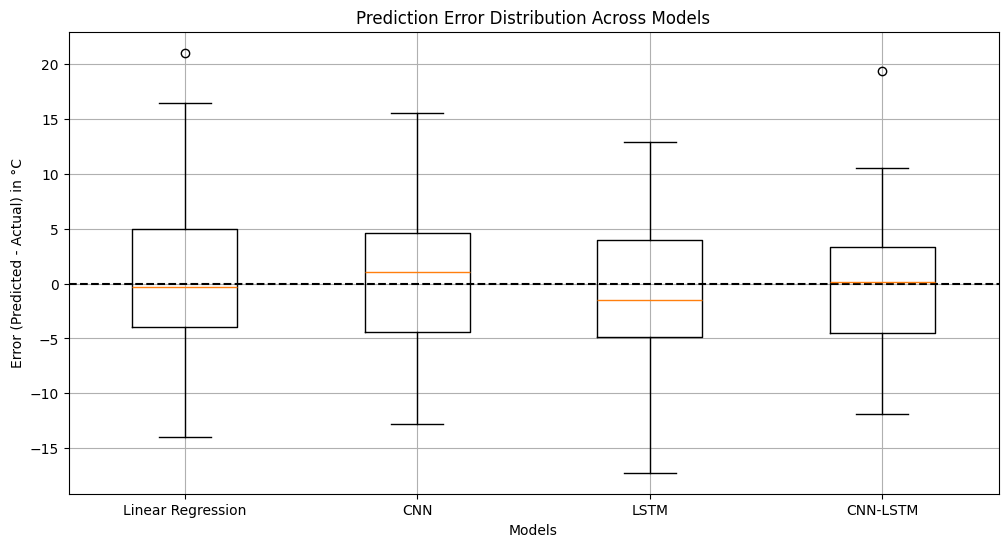

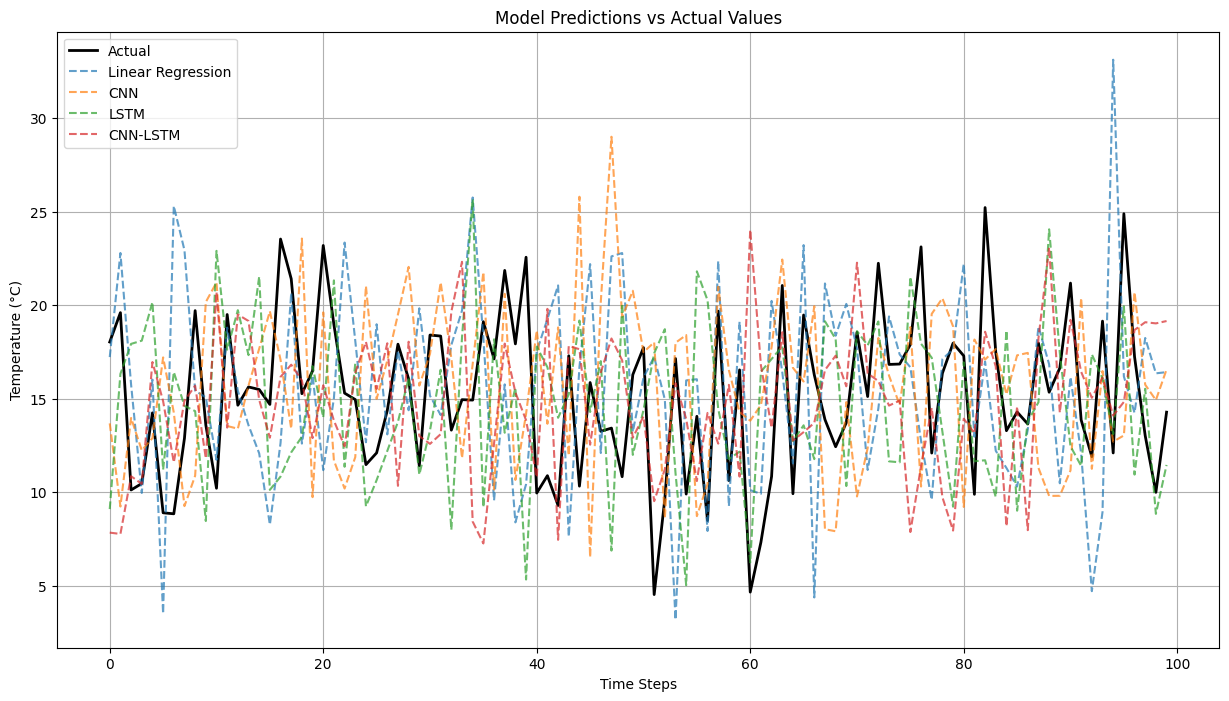


Model Performance Metrics:
               Model     MAE Avg Error Std Dev
3           CNN-LSTM  4.64°C   -0.42°C  5.65°C
2               LSTM  5.02°C   -0.44°C  6.05°C
0  Linear Regression  5.11°C    0.35°C  6.52°C
1                CNN  5.15°C    0.49°C  6.19°C


In [13]:
# Example data structure (replace actual predictions)
final_predictions = {
    'Actual': np.random.normal(15, 5, 100),  # Sample actual temperatures
    'Linear Regression': np.random.normal(16, 5, 100),
    'CNN': np.random.normal(15.5, 4.8, 100),
    'LSTM': np.random.normal(15.2, 4.5, 100),
    'CNN-LSTM': np.random.normal(15.1, 4.3, 100)
}

# Error Distribution Plot
plt.figure(figsize=(12, 6))
errors = {}
for name in final_predictions:
    if name != 'Actual':
        errors[name] = final_predictions[name] - final_predictions['Actual']

plt.boxplot(errors.values(), labels=errors.keys())
plt.axhline(0, color='black', linestyle='--')
plt.title('Prediction Error Distribution Across Models')
plt.ylabel('Error (Predicted - Actual) in °C')
plt.xlabel('Models')
plt.grid(True)
plt.show()

# Time Series Comparison Plot
plt.figure(figsize=(15, 8))
for name, values in final_predictions.items():
    if name == 'Actual':
        plt.plot(values, label=name, color='black', linewidth=2)
    else:
        plt.plot(values, label=name, alpha=0.7, linestyle='--')

plt.title('Model Predictions vs Actual Values')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time Steps')
plt.legend()
plt.grid(True)
plt.show()

# Metrics Table
metrics = []
for name in final_predictions:
    if name != 'Actual':
        mae = mean_absolute_error(final_predictions['Actual'], final_predictions[name])
        metrics.append({
            'Model': name,
            'MAE': f"{mae:.2f}°C",
            'Avg Error': f"{np.mean(errors[name]):.2f}°C",
            'Std Dev': f"{np.std(errors[name]):.2f}°C"
        })

print("\nModel Performance Metrics:")
print(pd.DataFrame(metrics).sort_values('MAE'))